<img src="https://raw.githubusercontent.com/euroargodev/argopy/master/docs/_static/argopy_logo_long.png" alt="argopy logo" width="200"/> 

# Download and visualise BGC data over an ocean region

This notebook shows how to:
- download BGC-Argo data for a space/time domain
- plot a map with floats trajectory
- plot BGC data

## Import and set-up

In [1]:
from argopy import DataFetcher  # This is the class to work with Argo data
from argopy import ArgoIndex  #  This is the class to work with Argo index
from argopy import ArgoNVSReferenceTables  # This is the class to retrieve data from Argo reference tables
from argopy import ArgoColors  # This is a class with usefull pre-defined colors
from argopy.plot import scatter_map, scatter_plot  # This is a function to easily make maps 

# Make a fresh start
import argopy
argopy.reset_options()
argopy.clear_cache()
argopy.set_options(cachedir='cache_bgc')

#
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import xarray as xr
xr.set_options(display_expand_attrs = False)

In [2]:
import logging
logging.getLogger("matplotlib").setLevel(logging.ERROR)
logging.getLogger("pyproj").setLevel(logging.ERROR)
logging.getLogger("fsspec").setLevel(logging.ERROR)
logging.getLogger("parso").setLevel(logging.ERROR)
logging.getLogger("asyncio").setLevel(logging.ERROR)
DEBUGFORMATTER = '%(asctime)s [%(levelname)s] [%(name)s] %(filename)s:%(lineno)d: %(message)s'
logging.basicConfig(
    level=logging.DEBUG,
    format=DEBUGFORMATTER,
    datefmt='%I:%M:%S %p',
    handlers=[logging.FileHandler("nb-docs.log", mode='w')]
)

## Define an ocean region to work with

For this demo notebook, we'll work with BGC floats in the Labrador Sea

For your own use, you can simply overwrite the ``BOX`` variable content with your region.

In [3]:
# Format: [lon_min, lon_max, lat_min, lat_max, pres_min, pres_max, datim_min, datim_max]
BOX = [-56, -45, 54, 60, 0, 2000, '2022-01', '2023-01']
# BOX = [-56, -45, 54, 60, 0, 2000, '2022-09', '2023-01']
BOX = [-56, -45, 54, 60, 0, 500, '2019-01', '2023-01']
# BOX = [-75, -62, 38, 42, 0, 2000, '2021-01', '2022-01']

## Get more info about this region using the ArgoIndex

In [4]:
# Load the BGC-synthetic profiles index
# rq: we work with synthetic profiles because that's the only dataset available from the erddap at this point (2023/07/21)
idx = ArgoIndex(index_file='bgc-s').load()  
idx

<argoindex.pyarrow>
Host: https://data-argo.ifremer.fr
Index: argo_synthetic-profile_index.txt.gz
Convention: argo_synthetic-profile_index (Synthetic-Profile directory file of the Argo GDAC)
In memory: True (376088 records)
Searched: False

In [6]:
# Select profile in a space/time domain:
index_BOX = [BOX[ii] for ii in [0, 1, 2, 3, 6, 7]]  # We don't want the pressure range
idx.query.box(index_BOX)

<argoindex.pyarrow>
Host: https://data-argo.ifremer.fr
Index: argo_synthetic-profile_index.txt.gz
Convention: argo_synthetic-profile_index (Synthetic-Profile directory file of the Argo GDAC)
In memory: True (376088 records)
Searched: True (1464 matches, 0.3893%) - {'BOX': [-56, -45, 54, 60, '2019-01', '2023-01']}

In [7]:
# Get the list of all parameters for this region:
idx.read_params()

['BBP700',
 'CDOM',
 'CHLA',
 'CHLA_FLUORESCENCE',
 'CP660',
 'DOWNWELLING_PAR',
 'DOWN_IRRADIANCE380',
 'DOWN_IRRADIANCE412',
 'DOWN_IRRADIANCE490',
 'DOXY',
 'NITRATE',
 'PH_IN_SITU_TOTAL',
 'PRES',
 'PSAL',
 'TEMP']

In [8]:
# Extract the list of BGC parameters:
bgc_params = idx.read_params()
[bgc_params.remove(p) for p in ['PRES', 'TEMP', 'PSAL']]  # Remove core variables from the list
bgc_params

['BBP700',
 'CDOM',
 'CHLA',
 'CHLA_FLUORESCENCE',
 'CP660',
 'DOWNWELLING_PAR',
 'DOWN_IRRADIANCE380',
 'DOWN_IRRADIANCE412',
 'DOWN_IRRADIANCE490',
 'DOXY',
 'NITRATE',
 'PH_IN_SITU_TOTAL']

In [9]:
# How many different floats in the region:
len(idx.read_wmo())

51

## Load all data from this region

- If the BOX has a lot of profiles, the request can take up to a few minutes.  
In the following ``DataFetcher`` command, we use the ``parallel`` option to chunk the requests into a collection of smaller domains (with a maximum length of 30 days)

In [10]:
%%time
# f = DataFetcher(ds='bgc', mode='expert', params='all', parallel=True, progress=True).region(BOX).load()  # Fetch everything !
f = DataFetcher(ds='bgc', mode='expert', params='all',
                parallel=True, progress=True, cache=False,
                chunks_maxsize={'time': 30},
               )
f = f.region(BOX).load()
f

Final post-processing of the merged dataset ...


/Users/gmaze/git/github/euroargodev/argopy/argopy/extensions/params_data_mode.py:117: FutureWarning: Note that the long name for institution is now in 'institution_name' while the 'institution' column will hold the institution code -- Deprecated since version 1.4
  df = idx.to_dataframe(completed=False)
/Users/gmaze/git/github/euroargodev/argopy/argopy/fetchers.py:795: FutureWarning: Note that the long name for institution is now in 'institution_name' while the 'institution' column will hold the institution code -- Deprecated since version 1.4
  df = idx.to_dataframe()


CPU times: user 1min 21s, sys: 3.25 s, total: 1min 24s
Wall time: 2min 5s


<datafetcher.erddap>
⭐ Name: Ifremer erddap Argo BGC data fetcher for a space/time region
🗺  Domain: [x=-56.00/-45.00; y=54.00/60.00; z=0.0/500.0; t=2019-01-01/2023-01-01]
🔗 API: https://erddap.ifremer.fr/erddap
📗 Parameters: ['BBP700', 'CDOM', 'CHLA', 'CP660', 'DOWNWELLING_PAR', 'DOWN_IRRADIANCE380', 'DOWN_IRRADIANCE412', 'DOWN_IRRADIANCE490', 'DOXY', 'NITRATE', 'PH_IN_SITU_TOTAL', 'PRES', 'PSAL', 'TEMP']
📕 BGC 'must be measured' parameters: []
🏄 User mode: expert
🟢 Dataset: bgc-s
🌤  Performances: cache=False, parallel=True [thread]

In [11]:
# Check the data structure (xarray.dataset):
ds = f.data
ds

<xarray.Dataset> Size: 383MB
Dimensions:                            (N_POINTS: 729984)
Coordinates:
    LATITUDE                           (N_POINTS) float64 6MB 56.93 ... 59.3
    LONGITUDE                          (N_POINTS) float64 6MB -52.52 ... -54.86
    TIME                               (N_POINTS) datetime64[ns] 6MB 2019-01-...
  * N_POINTS                           (N_POINTS) int64 6MB 0 1 ... 729983
Data variables: (12/90)
    BBP700                             (N_POINTS) float32 3MB nan nan ... nan
    BBP700_ADJUSTED                    (N_POINTS) float32 3MB nan nan ... nan
    BBP700_ADJUSTED_ERROR              (N_POINTS) float32 3MB nan nan ... nan
    BBP700_ADJUSTED_QC                 (N_POINTS) int64 6MB 99999 99999 ... 9 9
    BBP700_DATA_MODE                   (N_POINTS) <U1 3MB '' '' '' ... '' '' ''
    BBP700_QC                          (N_POINTS) int64 6MB 99999 99999 ... 9 9
    ...                                 ...
    TEMP_ADJUSTED                      (N_POINTS) float32 3MB 3.108 3.11 ... nan
    TEMP_ADJUSTED_ERROR                (N_POINTS) float32 3MB 0.002 ... nan
    TEMP_ADJUSTED_QC                   (N_POINTS) int64 6MB 1 1 1 1 ... 9 9 9 9
    TEMP_DATA_MODE                     (N_POINTS) <U1 3MB 'D' 'D' ... 'R' 'R'
    TEMP_QC                            (N_POINTS) int64 6MB 1 1 1 1 ... 1 1 1 1
    TIME_QC                            (N_POINTS) int64 6MB 1 1 1 1 ... 1 1 1 1
Attributes: (7)

In [54]:
ds = ds.persist()

In [12]:
# Check the data through the argo xarray accessor:
ds.argo

<xarray.Dataset.argo>
This is a collection of Argo points
N_POINTS(729984) ~ N_PROF(1468) x N_LEVELS(1420)

In [13]:
# and check the corresponding index structure (pandas.dataframe):
df = f.index
df

file                date  \
0          aoml/4903365/profiles/SD4903365_010.nc 2021-11-11 04:59:42   
1          aoml/4903365/profiles/SD4903365_011.nc 2021-11-21 03:43:40   
2      coriolis/1902578/profiles/SR1902578_001.nc 2022-05-30 05:01:26   
3     coriolis/1902578/profiles/SR1902578_001D.nc 2022-05-29 12:11:57   
4      coriolis/1902578/profiles/SR1902578_002.nc 2022-05-31 14:23:37   
...                                           ...                 ...   
1459       meds/4902580/profiles/SR4902580_020.nc 2022-11-26 05:13:00   
1460       meds/4902580/profiles/SR4902580_021.nc 2022-12-06 10:14:00   
1461       meds/4902580/profiles/SR4902580_022.nc 2022-12-16 15:15:00   
1462       meds/4902580/profiles/SR4902580_023.nc 2022-12-26 20:09:00   
1463       meds/4902581/profiles/SR4902581_001.nc 2022-05-21 06:14:00   

      latitude  longitude ocean  profiler_code institution  \
0       57.866    -46.017     A            869          AO   
1       57.474    -46.290     A            869          AO   
2       56.757    -52.358     A            834          IF   
3       56.816    -52.257     A            834          IF   
4       56.664    -52.604     A            834          IF   
...        ...        ...   ...            ...         ...   
1459    58.192    -49.489     A            844          ME   
1460    57.670    -49.399     A            844          ME   
1461    57.577    -50.442     A            844          ME   
1462    57.594    -49.279     A            844          ME   
1463    56.819    -52.518     A            844          ME   

                                             parameters parameter_data_mode  \
0     PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...          DDDAAAARDD   
1     PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...          DDDAAAARDD   
2     PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...          RRRAAAARRR   
3     PRES TEMP PSAL CHLA CHLA_FLUORESCENCE BBP700 C...            RRRAAARR   
4     PRES TEMP PSAL DOXY CHLA CHLA_FLUORESCENCE BBP...          RRRAAAARRR   
...                                                 ...                 ...   
1459                                PRES TEMP PSAL DOXY                RRRR   
1460                                PRES TEMP PSAL DOXY                RRRR   
1461                                PRES TEMP PSAL DOXY                RRRR   
1462                                PRES TEMP PSAL DOXY                RRRR   
1463                                PRES TEMP PSAL DOXY                RRRR   

             date_update      wmo  cyc institution_name       dac  \
0    2025-12-24 12:53:38  4903365   10        AOML, USA      aoml   
1    2025-12-24 12:53:49  4903365   11        AOML, USA      aoml   
2    2025-03-25 14:11:43  1902578    1  Ifremer, France  coriolis   
3    2025-03-25 14:11:33  1902578    1  Ifremer, France  coriolis   
4    2025-03-25 14:11:54  1902578    2  Ifremer, France  coriolis   
...                  ...      ...  ...              ...       ...   
1459 2025-08-28 14:20:52  4902580   20     MEDS, Canada      meds   
1460 2025-08-28 14:21:03  4902580   21     MEDS, Canada      meds   
1461 2025-08-28 14:21:13  4902580   22     MEDS, Canada      meds   
1462 2025-08-28 14:21:24  4902580   23     MEDS, Canada      meds   
1463 2024-01-23 02:09:40  4902581    1     MEDS, Canada      meds   

                                      profiler  
0                                    NAVIS_EBR  
1                                    NAVIS_EBR  
2                                 PROVOR V SBE  
3                                 PROVOR V SBE  
4                                 PROVOR V SBE  
...                                        ...  
1459  ARVOR float with SBE conductivity sensor  
1460  ARVOR float with SBE conductivity sensor  
1461  ARVOR float with SBE conductivity sensor  
1462  ARVOR float with SBE conductivity sensor  
1463  ARVOR float with SBE conductivity sensor  

[1461 rows x 15 columns]

## Make a map with all floats trajectory

Rq: we could have done this without downloading the data by working directly with the ArgoIndex

```python
scatter_map(idx.to_dataframe(), set_global=False);
```

(<Figure size 900x540 with 1 Axes>,
 <GeoAxes: xlabel='longitude', ylabel='latitude'>)

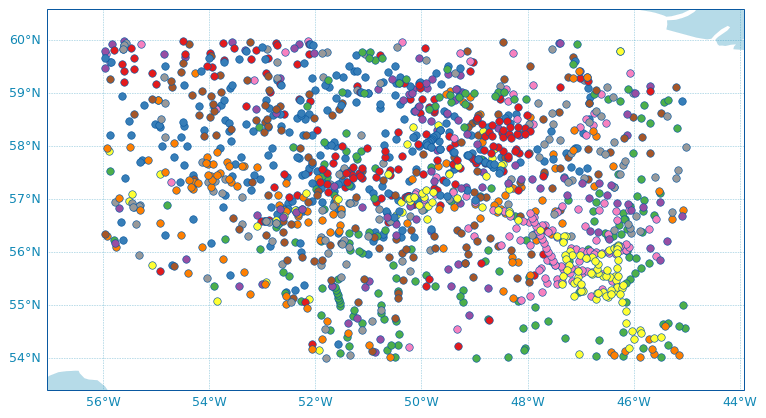

In [17]:
f.plot('trajectory', traj=False, legend=False)

## Make a map with one BGC parameter data mode

We can also make a scatter map with one BGC parameter data mode.

In [23]:
# Randomly select one BGC parameter to work with:
a_param = bgc_params[np.random.randint(len(bgc_params))]
a_param

'DOWNWELLING_PAR'

In [24]:
# Get more verbose information about this parameter (usefull for plot titles):
reftbl = ArgoNVSReferenceTables().tbl('R03')
param_info = reftbl[reftbl['altLabel']==a_param].iloc[0].to_dict()
param_info

{'altLabel': 'DOWNWELLING_PAR',
 'prefLabel': 'Downwelling photosynthetic available radiation',
 'definition': 'Downwelling Photosynthetically Available Radiation (PAR). Local_Attributes:{long_name:Downwelling photosynthetic available radiation; standard_name:downwelling_photosynthetic_photon_flux_in_sea_water; units:microMoleQuanta/m^2/sec; valid_min:-; valid_max:-; fill_value:99999.f}. Properties:{category:b; data_type:float}',
 'deprecated': 'false',
 'id': 'http://vocab.nerc.ac.uk/collection/R03/current/DOWNWELLING_PAR/'}

In [31]:
# To make the scatter map, we need to have the data mode available in one DataFrame column
# so we need to add a new column with the DATA_MODE of the PARAMETER:
df["variables"] = df["parameters"].apply(lambda x: x.split())
df["%s_DM" % a_param] = df.apply(lambda x: x['parameter_data_mode'][x['variables'].index(a_param)] if a_param in x['variables'] else '', axis=1)

In [32]:
np.unique(df["%s_DM" % a_param])

array(['', 'D', 'R'], dtype=object)

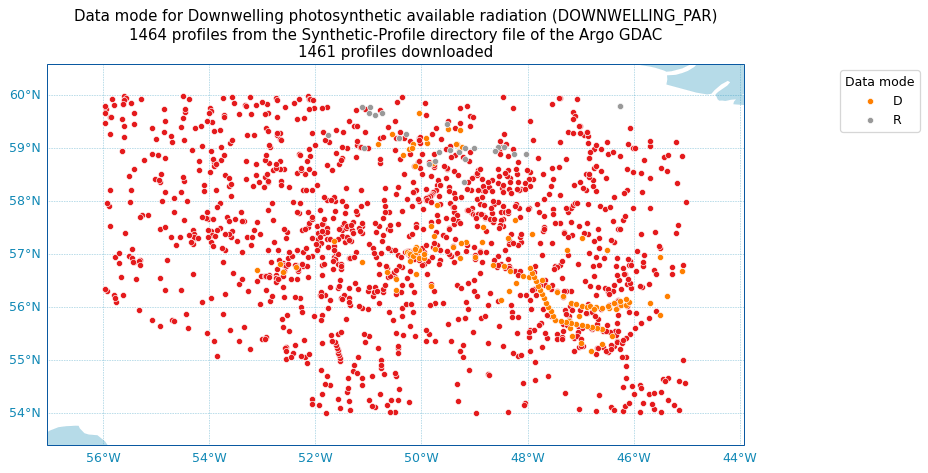

In [36]:
# Finally plot the map:
fig, ax, _ = scatter_map(df,
                        hue="%s_DM" % a_param,
                        markersize=24,
                        markeredgecolor='w',
                        traj=False,
                        legend_title='Data mode')
ax.set_title("Data mode for %s (%s)\n%i profiles from the %s\n%i profiles downloaded" % (param_info['prefLabel'], a_param, 
                                                                           idx.N_MATCH, idx.convention_title, df.shape[0]));

**Rq**: If some points have no data mode in the above map, it simply means that these profiles have not the request parameters

## Plot 

### Utilities

We will be using the argopy scatter_plot method that has the following signature:

```
scatter_plot(
    ds: xarray.core.dataset.Dataset,
    this_param,
    this_x='TIME',
    this_y='PRES',
    figsize=(18, 6),
    cmap=None,
    vmin=None,
    vmax=None,
    s=4,
)
```

In [37]:
# Try to define readible color bounds for each BGC variables 
# (this is probably NOT appropriate for all regions and periods !)
c_bounds = {'BBP700': (20e-5, 70e-5),
            'CDOM': (0.4, 0.8),
            'CHLA': (0, 0.2),
            'DOWNWELLING_PAR': (0, 10),
            'DOWN_IRRADIANCE380': (0, .1),
            'DOWN_IRRADIANCE412': (0, .1),
            'DOWN_IRRADIANCE490': (0, .1),
            'DOXY': (250,300),
            'NITRATE': (-2, 20),
            'PH_IN_SITU_TOTAL': (6, 8.5),
           }

In [38]:
# We''l make use of the argopy color scheme:
ArgoColors('qc')

### Plot some data QC

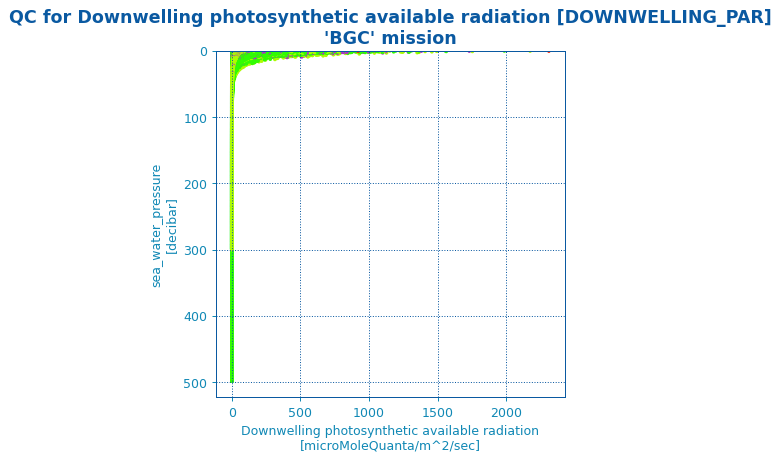

In [44]:
fig, ax, _ = scatter_plot(ds, f"{a_param}_QC", x = a_param, figsize=(5,5))
ax.set_title("QC for %s [%s]\n'%s' mission" % (param_info['prefLabel'], a_param, f.mission), 
             fontdict={'weight': 'bold', 'size': 14});

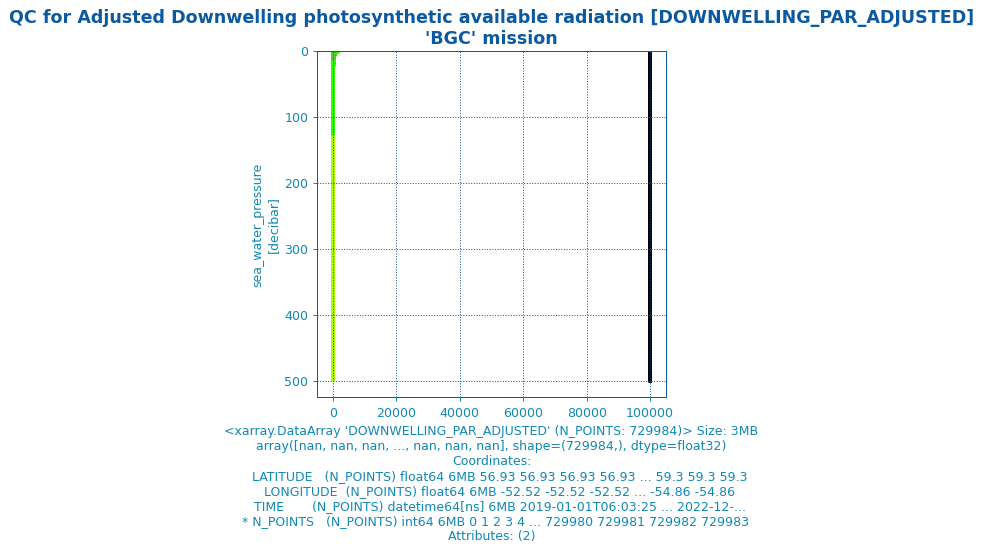

In [46]:
fig, ax, _ = scatter_plot(ds, f"{a_param}_ADJUSTED_QC", x = f"{a_param}_ADJUSTED", figsize=(5,5))
ax.set_title("QC for Adjusted %s [%s]\n'%s' mission" % (param_info['prefLabel'], a_param + '_ADJUSTED', f.mission), fontdict={'weight': 'bold', 'size': 14});

### Plot some variable against another

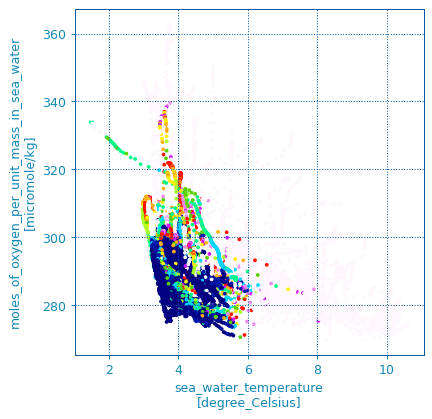

In [50]:
vmin, vmax = c_bounds['CHLA']
fig, ax, _ = scatter_plot(ds, 'CHLA_ADJUSTED', x = 'TEMP_ADJUSTED', y = 'DOXY_ADJUSTED',
                          vmin=vmin, vmax=vmax, figsize=(5,5))

### Plot time series

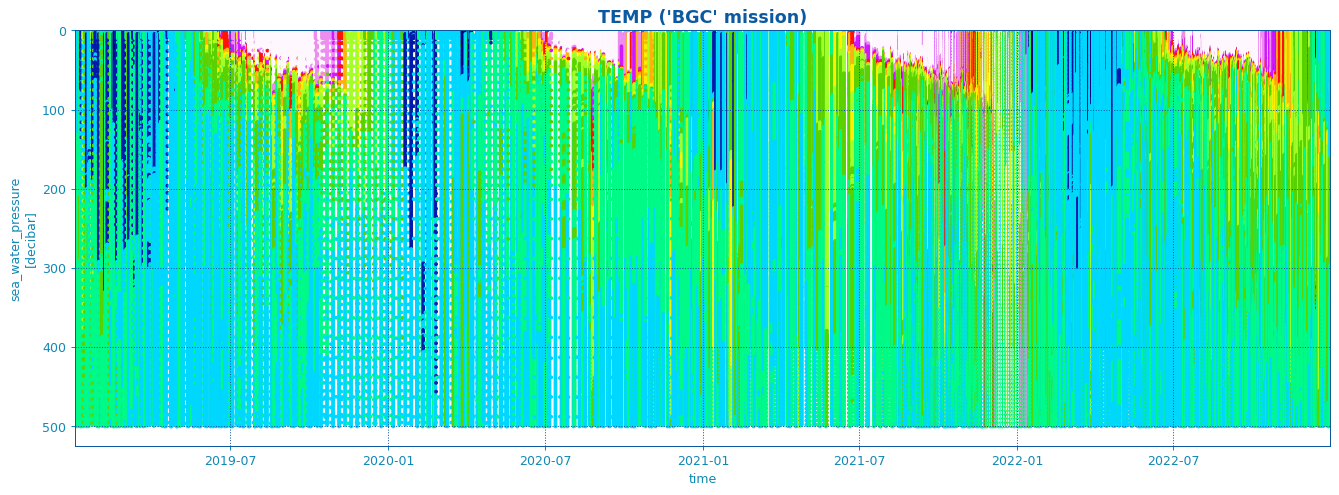

In [55]:
fig, ax, _ = scatter_plot(ds, 'TEMP', vmin=2, vmax=8)
ax.set_title("%s ('%s' mission)" % ('TEMP', f.mission), fontdict={'weight': 'bold', 'size': 14});

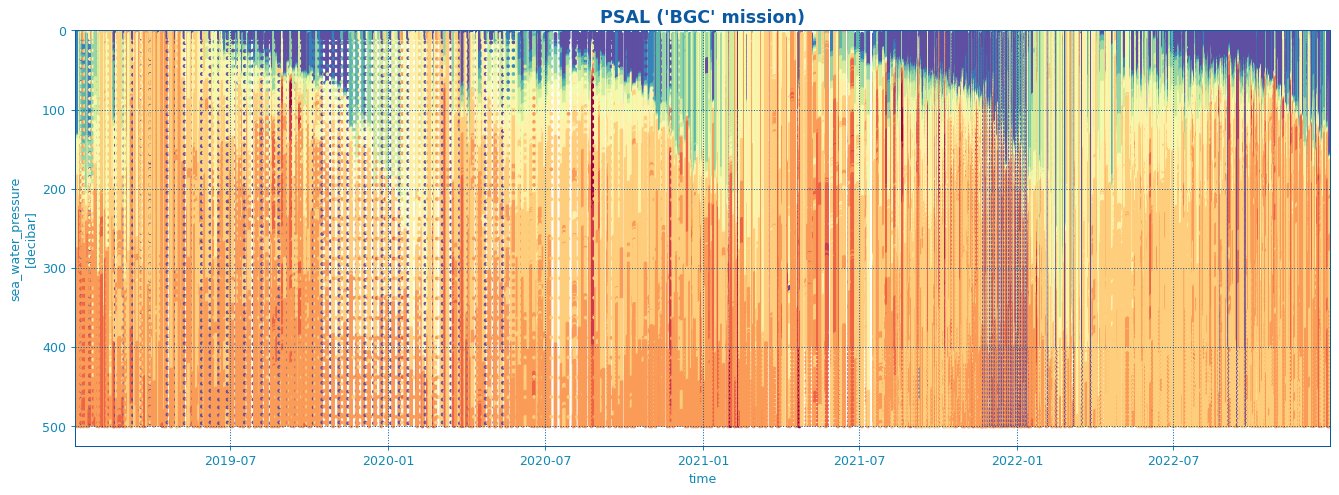

In [57]:
fig, ax, _ = scatter_plot(ds, 'PSAL', cmap='Spectral_r', vmin=34.5, vmax=35)
ax.set_title("%s ('%s' mission)" % ('PSAL', f.mission), fontdict={'weight': 'bold', 'size': 14});

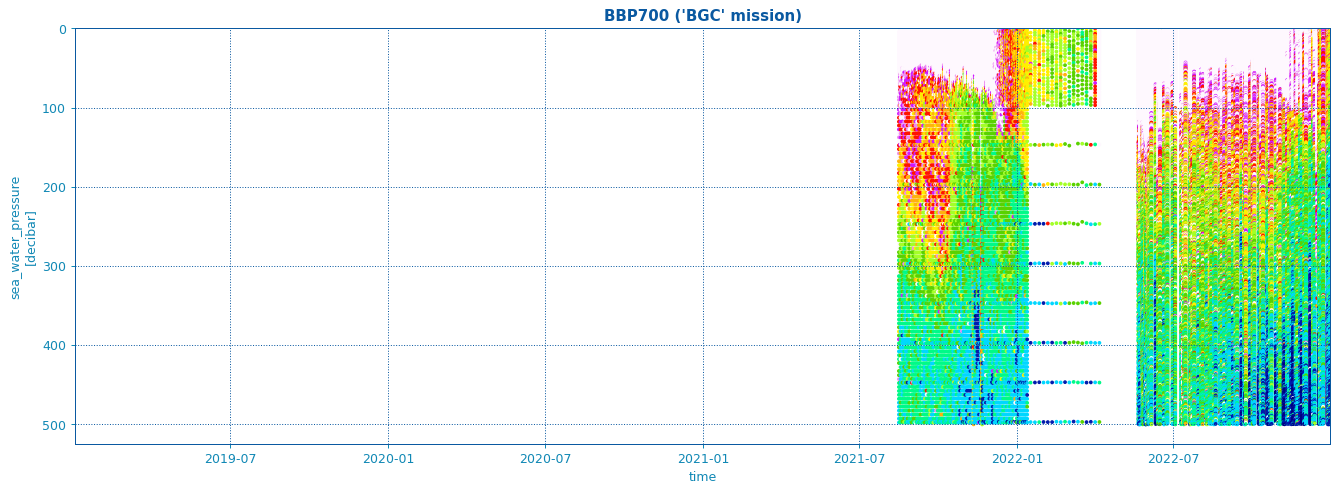

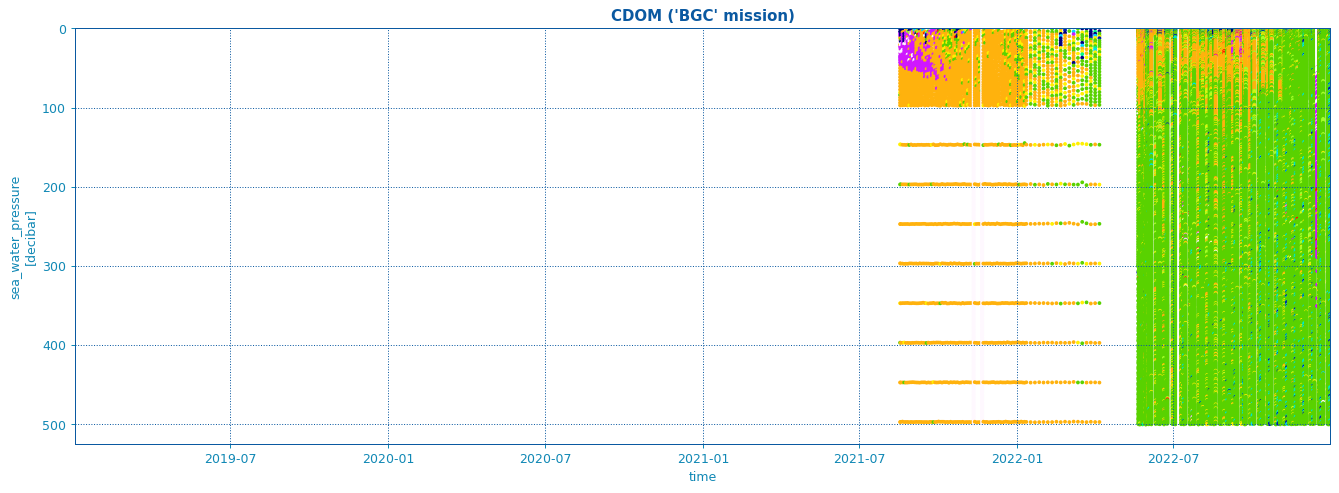

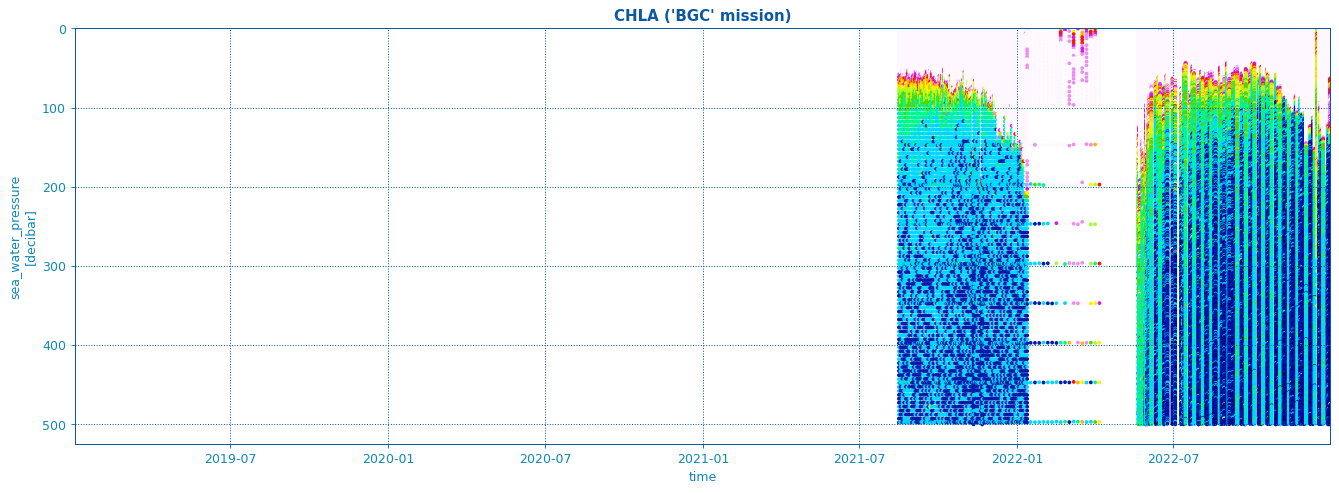

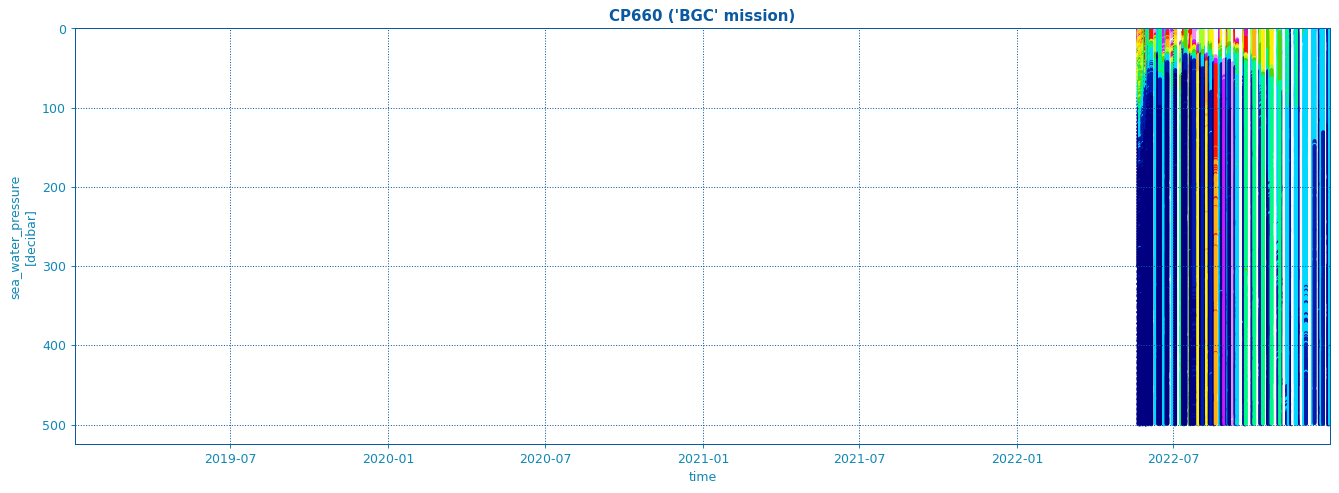

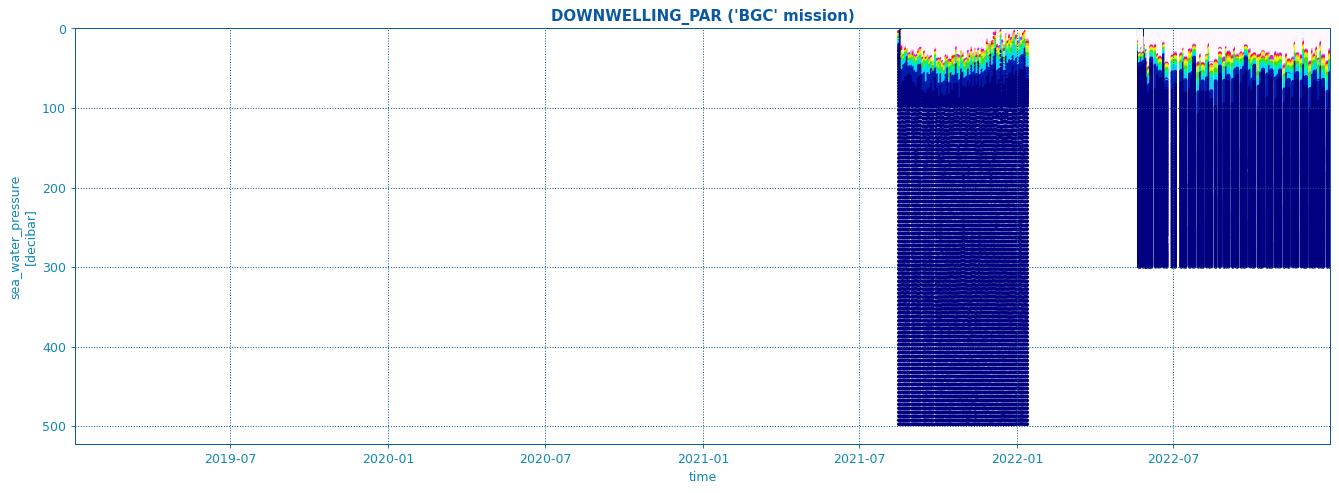

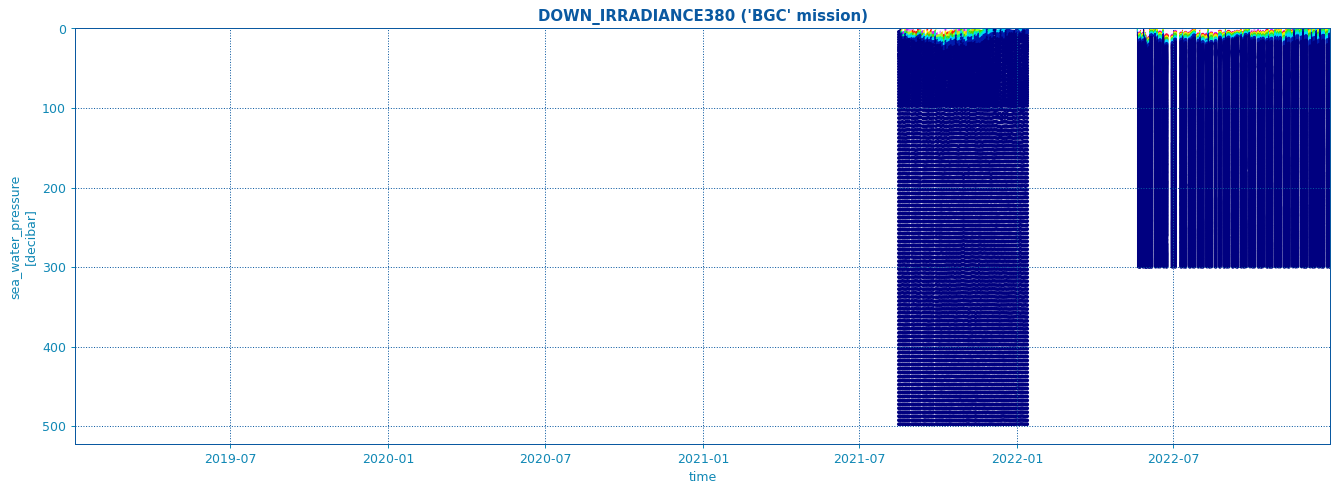

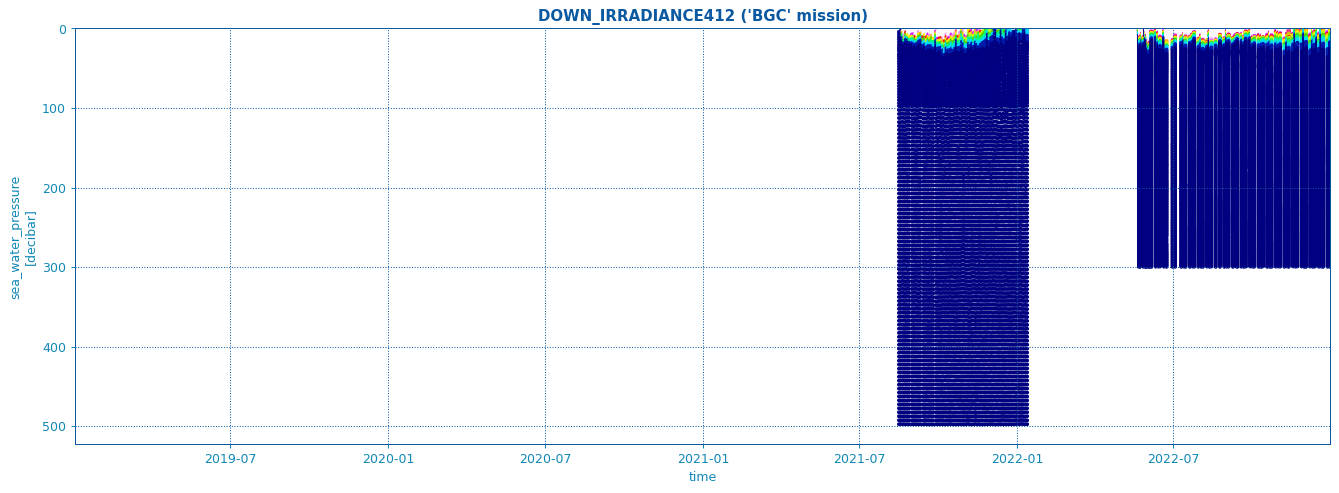

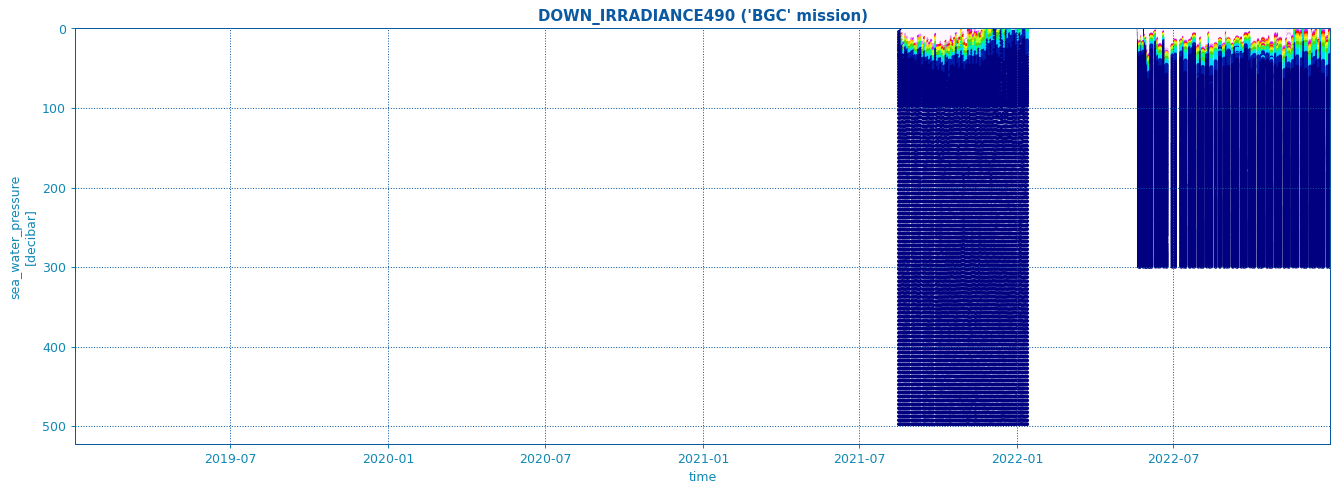

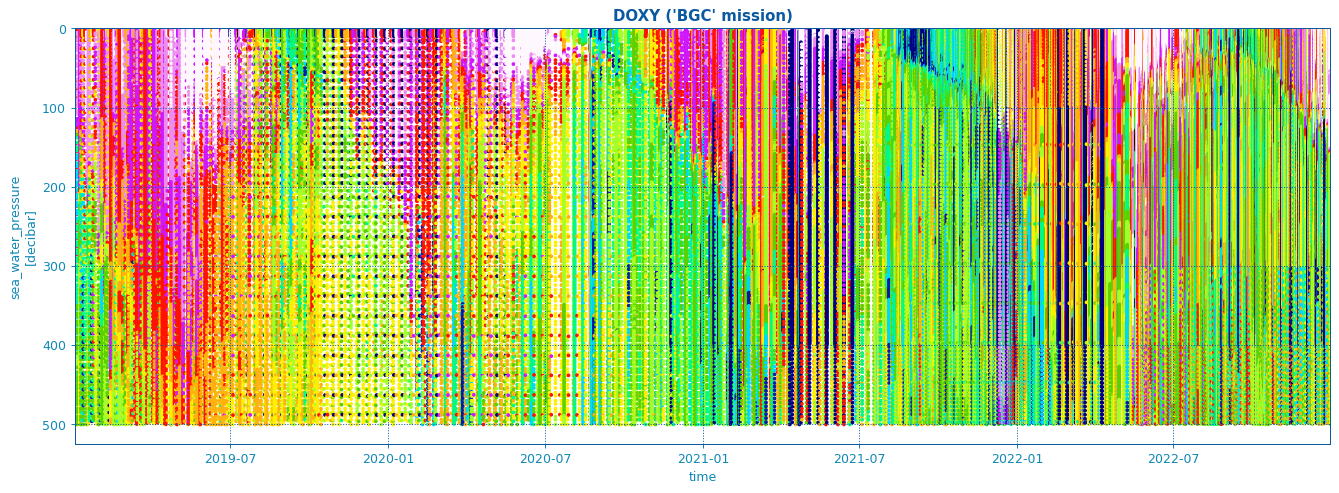

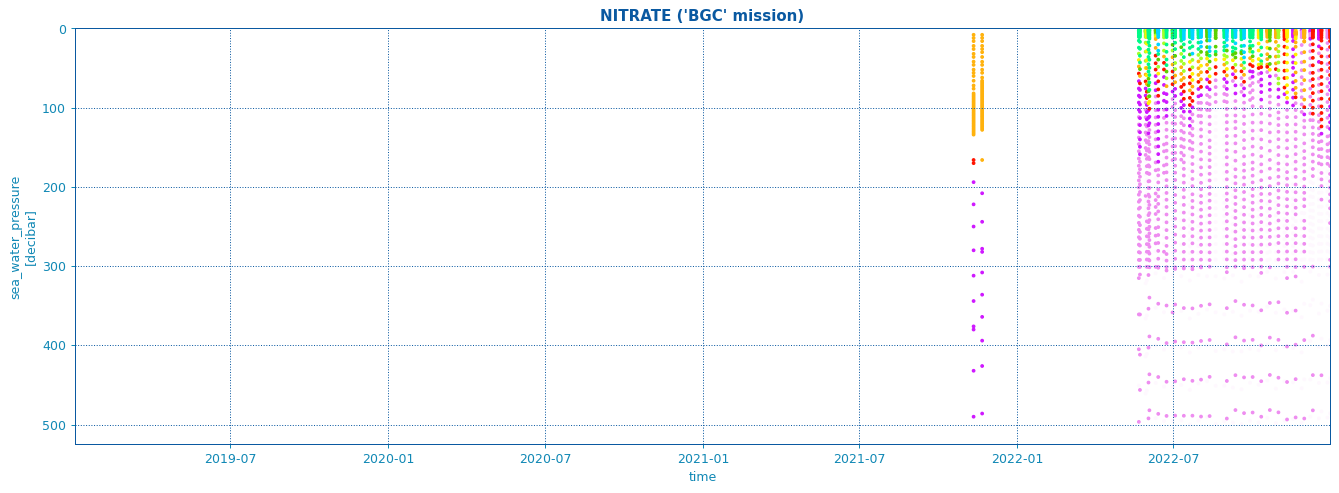

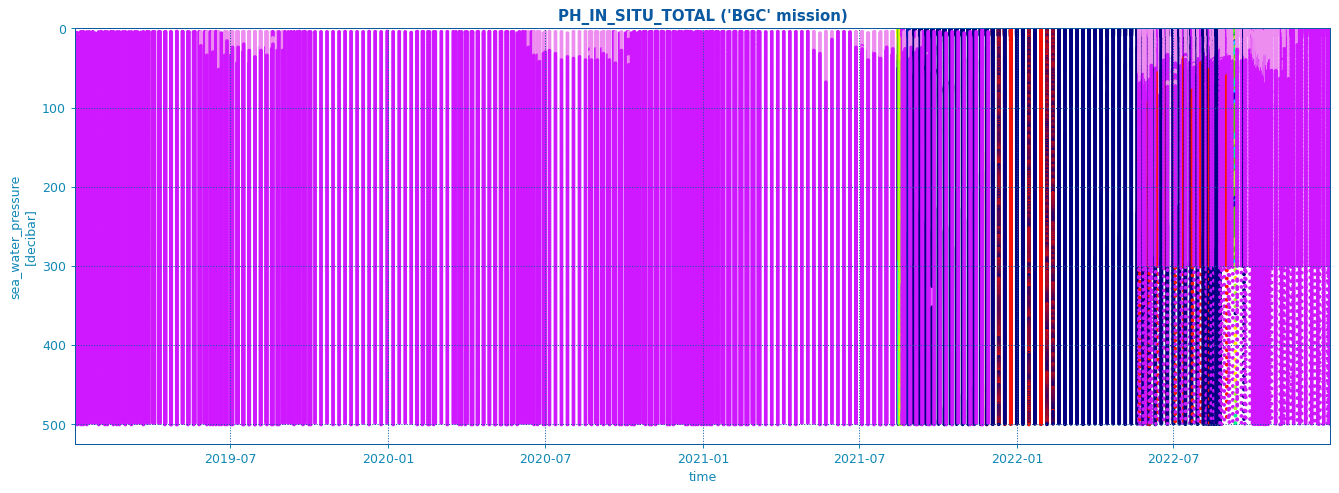

In [59]:
# Plot all BGC params
for param in bgc_params:
    if param in ds:
        vmin, vmax = c_bounds[param] if param in c_bounds else (None, None)
        fig, ax, _ = scatter_plot(ds, param, vmin=vmin, vmax=vmax)
        ax.set_title("%s ('%s' mission)" % (param, f.mission), fontdict={'weight': 'bold', 'size': 12});